In [136]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import silhouette_samples, silhouette_score
from matplotlib import pyplot as plt
import matplotlib as mpl
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import KFold, cross_val_score, ShuffleSplit, train_test_split
from scipy.stats import linregress
mpl.rcParams['figure.dpi'] = 100

In [137]:
data = pd.read_csv("Al_cast_alloys.csv")
labels = data["Grade"]
y = data["TensileStrength"]
data = data.drop(["Grade","TensileStrength"],axis=1)
data.head()
cv = ShuffleSplit(n_splits=10,random_state=123)

In [138]:
#Split the data into test and train datasets, then visualize the splitting for testing purposes
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state=123)
# plt.scatter(X_train["AgingTemp"],y_train,s=10,alpha=.5)
# plt.scatter(X_test["AgingTemp"],y_test,s=10,alpha=.5)
# plt.legend(["Train","Test"])

Test the multiple linear regression

In [139]:
linmodel = LinearRegression()
#Test the k-fold cross validation r^2 values
cross_val_score(linmodel,data,y,cv=cv,scoring="r2")


array([0.78068994, 0.8156605 , 0.6807449 , 0.85483113, 0.81521711,
       0.77791498, 0.83770027, 0.82966281, 0.86298047, 0.84030946])

Text(0, 0.5, 'Predicted Tensile Strength')

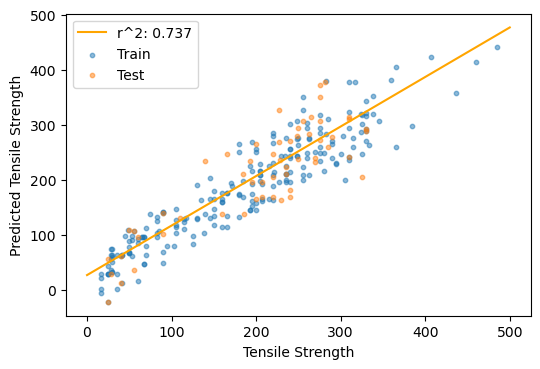

In [140]:
#Compare the predicted tensile strength values to the observed tensile strength values for the test and train datasets
linfit = linmodel.fit(X_train,y_train)
y_train_pred = linfit.predict(X_train)
y_test_pred = linfit.predict(X_test)
plt.scatter(y_train,y_train_pred,s=10,alpha=.5)
plt.scatter(y_test,y_test_pred,s=10,alpha=.5)
coeff = linregress(y_test,y_test_pred)
plt.plot(np.linspace(0,500,100), np.linspace(0,500,100)*coeff[0]+coeff[1],color="orange")
plt.legend(["r^2: "+str(np.round(coeff[2]**2,3)),"Train","Test"])
plt.xlabel("Tensile Strength")
plt.ylabel("Predicted Tensile Strength")


Test the LASSO model 

In [141]:
lasso = Lasso()
cross_val_score(lasso,data,y,cv=cv,scoring="r2")

array([0.71081595, 0.83861355, 0.53465293, 0.76143996, 0.77937526,
       0.7273359 , 0.82154149, 0.79211654, 0.77405587, 0.74929025])

Text(0, 0.5, 'Predicted Tensile Strength')

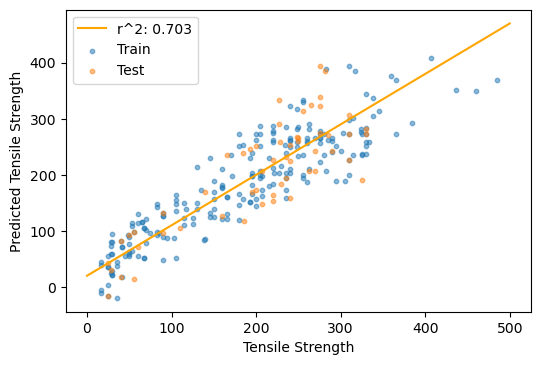

In [142]:
#Compare the predicted tensile strength values to the observed tensile strength values for the test and train datasets
lassofit = lasso.fit(X_train,y_train)
y_train_pred = lassofit.predict(X_train)
y_test_pred = lassofit.predict(X_test)
plt.scatter(y_train,y_train_pred,s=10,alpha=.5)
plt.scatter(y_test,y_test_pred,s=10,alpha=.5)
coeff = linregress(y_test,y_test_pred)
plt.plot(np.linspace(0,500,100), np.linspace(0,500,100)*coeff[0]+coeff[1],color="orange")
plt.legend(["r^2: "+str(np.round(coeff[2]**2,3)),"Train","Test"])
plt.xlabel("Tensile Strength")
plt.ylabel("Predicted Tensile Strength")

Compare the number of coefficients to the alpha value

(40,) (40,)


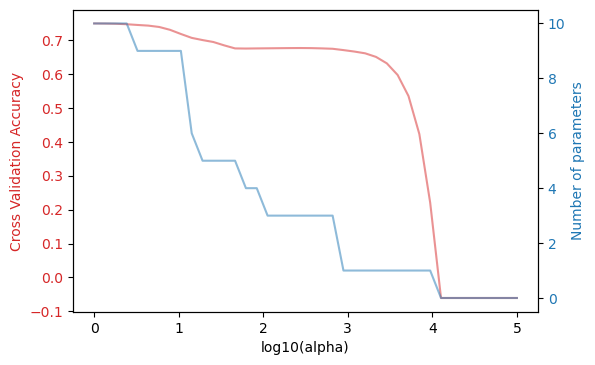

In [143]:
alpharange = np.linspace(0,5,40)
alpharange = np.power(10,alpharange)
crossval = np.zeros(alpharange.shape)
num_parameters = np.zeros(alpharange.shape)
for i in range(len(alpharange)):
    lassomodel = Lasso(alpha=alpharange[i],random_state=123)
    lassofit = lassomodel.fit(X_train,y_train)
    num_parameters[i] = np.count_nonzero(lassofit.coef_)
    crossval[i] = np.average(cross_val_score(lassomodel,data,y,cv=cv,scoring="r2"))


fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('log10(alpha)')
ax1.set_ylabel('Cross Validation Accuracy', color=color)
plt.plot(np.log10(alpharange),crossval, color = color,alpha = .5)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Number of parameters', color=color)  # we already handled the x-label with ax1
ax2.plot(np.log10(alpharange),num_parameters, color=color,alpha = .5)
ax2.tick_params(axis='y', labelcolor=color)
print(crossval.shape,alpharange.shape)



[0.76784936 0.768825   0.49923262 0.53581792 0.67836538 0.66967242
 0.80816338 0.78338955 0.6554878  0.58798074]
Index(['SolTemp', 'AgingTemp', 'ServiceTemp'], dtype='object')


(0.0, 500.0)

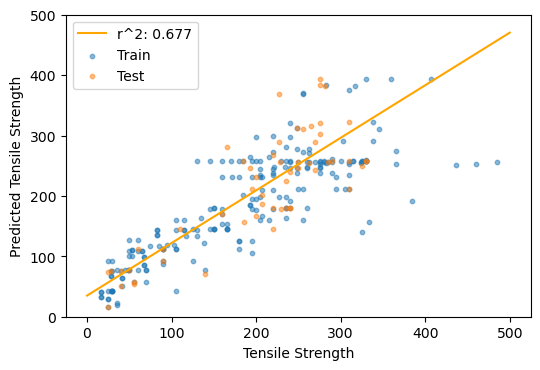

In [144]:
lasso = Lasso(alpha=100)
print(cross_val_score(lasso,data,y,cv=cv,scoring="r2"))

#Create a model that prioritises sparseness in the lasso coefficients
lassofit = lasso.fit(X_train,y_train)
#nonzeros = np.reshape(lassofit.coef_,(1,len(lassofit.coef_)))
#print(np.count_nonzero(nonzeros,axis=0,keepdims=True))
print(data.columns[np.nonzero(lassofit.coef_)])
y_train_pred = lassofit.predict(X_train)
y_test_pred = lassofit.predict(X_test)
plt.scatter(y_train,y_train_pred,s=10,alpha=.5)
plt.scatter(y_test,y_test_pred,s=10,alpha=.5)
coeff = linregress(y_test,y_test_pred)
plt.plot(np.linspace(0,500,100), np.linspace(0,500,100)*coeff[0]+coeff[1],color="orange")
plt.legend(["r^2: "+str(np.round(coeff[2]**2,3)),"Train","Test"])
plt.xlabel("Tensile Strength")
plt.ylabel("Predicted Tensile Strength")
plt.ylim(0,500)

Gaussian Process Regression

In [145]:
kernel=RBF(1)
gpr = GaussianProcessRegressor()
scaler = StandardScaler()
fit_scaler = scaler.fit(data)
scaled_data = fit_scaler.transform(data)

In [155]:
lrange = np.linspace(.01,1,10)
krange = [0.1,1,2,10]
crossval = np.zeros((len(lrange),len(krange)))
for i in range(len(lrange)):
    for j in range(len(krange)):
        kernel= krange[j]*RBF(lrange[i])
        gpr = GaussianProcessRegressor(kernel=kernel)
        crossval[i,j] = np.average(cross_val_score(gpr,scaled_data,y,cv=cv,scoring="r2"))

/Users/apple/opt/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/Users/apple/opt/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/Users/apple/opt/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:509: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/mod

KeyboardInterrupt: 

Text(0.5, 0, 'Kernel Length Scale')

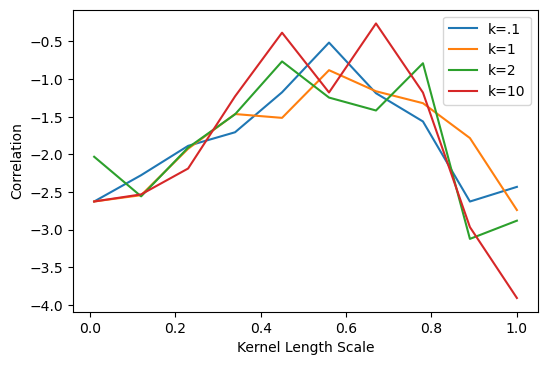

In [147]:
plt.plot(lrange,crossval[:,0])
plt.plot(lrange,crossval[:,1])
plt.plot(lrange,crossval[:,2])
plt.plot(lrange,crossval[:,3])
plt.legend(["k=.1","k=1","k=2","k=10"])
plt.ylabel("Correlation")
plt.xlabel("Kernel Length Scale")

Text(45.722222222222214, 0.5, 'L value')

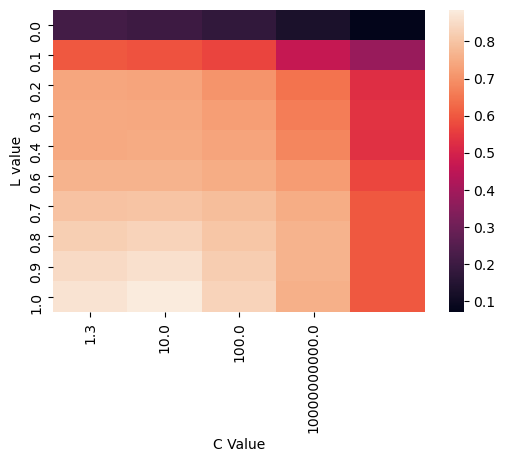

In [154]:
sns.heatmap(crossval,yticklabels=np.round(lrange,1),xticklabels=np.round(krange,1))
plt.xlabel("C Value")
plt.ylabel("L value")

/Users/apple/opt/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/apple/opt/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


Text(0, 0.5, 'Predicted Tensile Strength')

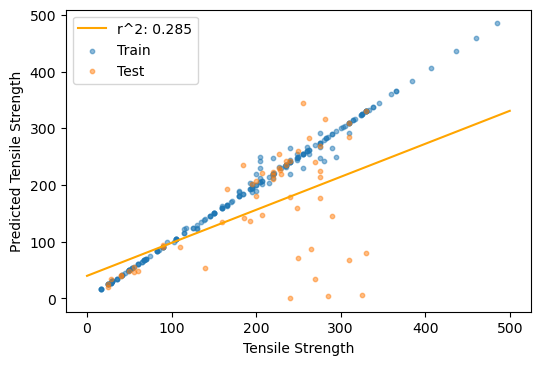

In [149]:
#Compare the predicted tensile strength values to the observed tensile strength values for the test and train datasets
gpr = GaussianProcessRegressor(kernel = 1*RBF(0.5))
gprfit = gpr.fit(fit_scaler.transform(X_train),y_train)
y_train_pred,y_train_std = gprfit.predict(fit_scaler.transform(X_train),return_std=True)
y_test_pred,y_test_std = gprfit.predict(fit_scaler.transform(X_test),return_std=True)
fig3, ax3 = plt.subplots()
plt.scatter(y_train,y_train_pred,s=10,alpha=.5)
plt.scatter(y_test,y_test_pred,s=10,alpha=.5)
coeff = linregress(y_test,y_test_pred)
plt.plot(np.linspace(0,500,100), np.linspace(0,500,100)*coeff[0]+coeff[1],color="orange")
plt.legend(["r^2: "+str(np.round(coeff[2]**2,3)),"Train","Test"])
plt.xlabel("Tensile Strength")
plt.ylabel("Predicted Tensile Strength")

Text(0, 0.5, 'Frequency')

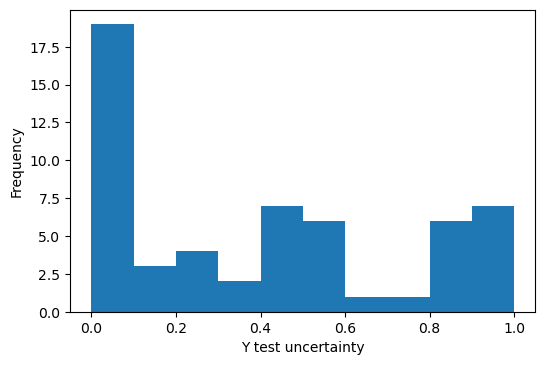

In [150]:
plt.hist(y_test_std)
plt.xlabel("Y test uncertainty")
plt.ylabel("Frequency")


Support Vector Regression

Text(0, 0.5, 'Predicted Tensile Strength')

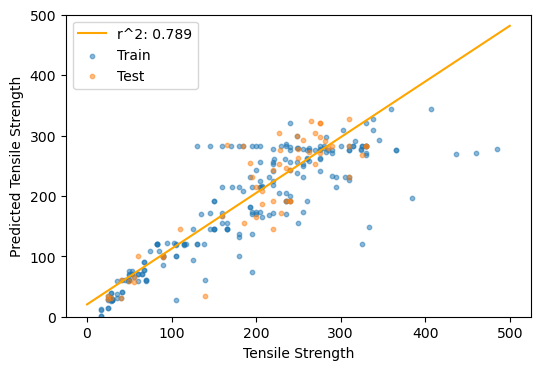

In [151]:
svm = SVR(kernel="rbf",C = 100,epsilon=10)

svr_fit = svm.fit(X_train,y_train)
y_train_pred = svr_fit.predict(X_train)
y_test_pred = svr_fit.predict(X_test)
plt.scatter(y_train,y_train_pred,s=10,alpha=.5)
plt.scatter(y_test,y_test_pred,s=10,alpha=.5)
coeff = linregress(y_test,y_test_pred)
plt.plot(np.linspace(0,500,100), np.linspace(0,500,100)*coeff[0]+coeff[1],color="orange")
plt.legend(["r^2: "+str(np.round(coeff[2]**2,3)),"Train","Test"])
plt.ylim((0,500))
plt.xlabel("Tensile Strength")
plt.ylabel("Predicted Tensile Strength")


In [152]:
c_list = np.linspace(0.1,6,10)
c_list = np.power(10,c_list)
epsilon_list = np.linspace(0.1,100,5)
crossval = np.zeros((len(c_list),len(epsilon_list)))

for i in range(len(c_list)):
    for j in range(len(epsilon_list)):
        svm = SVR(kernel="rbf",C=c_list[i],epsilon=epsilon_list[j])
        crossval[i,j] = np.average(cross_val_score(svm,data,y,cv=cv,scoring="r2"))
    


Text(45.722222222222214, 0.5, 'log10(C value)')

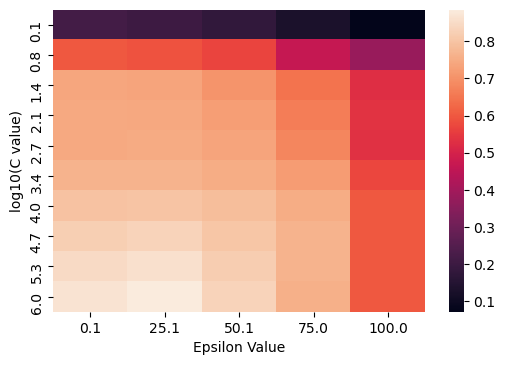

In [153]:
sns.heatmap(crossval,xticklabels=np.round(epsilon_list,1),yticklabels=np.round(np.log10(c_list),1))
plt.xlabel("Epsilon Value")
plt.ylabel("log10(C value)")